In [1]:
# 공통 코드

# 파이썬
# ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# 이미지를 저장할 디렉토리 생성
os.makedirs(IMAGES_PATH, exist_ok=True)

# 이미지 저장
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from matplotlib import font_manager, rc
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    
    
mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3

# 그래픽 출력을 좀 더 고급화하기 위한 라이브러리
import seaborn as sns

# 과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats

# 사이킷런 ≥0.20 필수
# 0.20 이상 버전에서 데이터 변환을 위한 Transformer 클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 노트북 실행 결과를 동일하게 유지하기 위해 시드 고정
# 데이터를 분할할 때 동일한 분할을 만들어 냄
np.random.seed(21)



## 분류 - Classification

### MNIST 데이터 - 손으로 쓴 숫자 이미지

In [3]:
# 데이터 다운로드
# dict 형태로 데이터를 다운로드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)


C:\Users\USER\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# 데이터 확인
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [5]:
# feature 와 target 가져와서 분류
# feature 는 주로 X, target 은 주로 y 로 표현

X, y = mnist['data'], mnist['target']
# 둘 다 크기가 7만으로 동일
# 데이터는 784 픽셀 크기인 흑백 이미지로 크기는 28x28
# 각 픽셀은 0 ~ 255 사이의 값
print(X.shape) # (70000, 784)
print(y.shape) # (70000,)

(70000, 784)
(70000,)


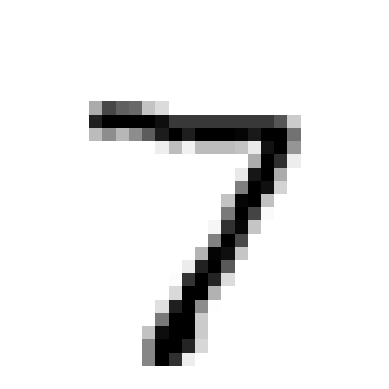

In [6]:
# 하나의 이미지 출력해서 확인

# 이미지 하나 가져오기 - 784 픽셀
one_digit_image = X[60000]
# 784x1 을 2차원인 28x28 로 변환
one_digit_image = one_digit_image.reshape(28, 28)

# 이미지 출력
plt.imshow(one_digit_image, cmap = mpl.cm.binary)
plt.axis('off')
plt.show()

In [7]:
# 출력해서 확인한 이미지의 레이블 확인
print(y[60000]) # 7

7


In [8]:
# 여러 개의 이미지를 출력하기 위한 함수
# 첫번째는 이미지들, 두번째는 하나의 행에 출력할 이미지의 수
# 세번째 매개변수는 옵션으로 dict 를 설정 - ** 사용
# 여러 옵션을 설정하는 경우 각각을 나열하는 것은 가독성을 떨어뜨림
# 이런 경우에 매개변수를 하나로 묶어야 하는데 dict 나 class 를 사용
# 생략이 가능한 옵션을 많이 가지고 있으면 dict 가 낫고 그렇지 않으면 class

def show_images(instances, images_per_row = 10, **options):
    # 이미지의 크기를 변수로 생성
    size = 28
    images_per_rows = min(len(instances), images_per_row)
    
    # 이미지의 크기 변환
    images = [image.reshape(size, size) for image in instances]
    
    # 행의 갯수 출력
    n_rows = (len(instances) -1) // images_per_row + 1
    
    # 이미지를 저장할 리스트
    image_list = []
    n_empty = n_rows * images_per_row - len(instances)
    
    images.append(np.zeros((size * size * n_empty)))
    
    # 행 단위로 순회하면서 실제 이미지 추가
    for row in range(n_rows):
        real_images = images[row * images_per_row : (row+1) * images_per_row]
        image_list.append(np.concatenate(real_images, axis = 1))
        
    image = np.concatenate(image_list, axis = 0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis('off')
    plt.show()
    

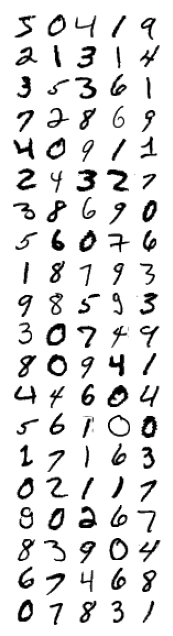

In [9]:
# 여러 개의 이미지 출력하는 함수 확인
plt.figure(figsize = (8, 8))
ex_images = X[:100]
show_images(ex_images, images_per_row = 5)


In [10]:
# target 의 자료형 확인
print(type(y)) # numpy.ndarray
print(type(y[0])) # str
print(y[0]) # str
# 범주형 데이터의 자료형은 정수형을 권장함

# target 의 자료형을 변경
y = y.astype(np.uint8)
print(type(y[0])) # numpy.uint8

<class 'numpy.ndarray'>
<class 'str'>
5
<class 'numpy.uint8'>


### 이진 분류를 위한 데이터 생성

In [11]:
# 훈련 데이터와 테스트 데이터 분리
# 데이터 셋이 만들어질 때 순서가 랜덤하게 변해있으므로
# 이전의 과정처럼 랜덤하게 데이터를 가져올 필요가 없음
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류는 True 와 False 로 분류함
# 이진 분류의 경우 target 이 bool 타입
# 8인지 아닌지로 분류하기 위한 데이터 생성
y_train_8 = (y_train == 8)
y_test_8 = (y_test == 8)
print(y_train[17]) # 8
print(y_train_8[17]) # True


8
True


## SGDClassifier 클래스를 이용한 분류

### 훈련 및 데이터 예측

In [12]:
from sklearn.linear_model import SGDClassifier

one_digit_image = X[60000]

# 훈련에 사용할 모델을 생성 - 하이퍼 파라미터 설정
# max_iter 는 최대 반복 횟수, tol 은 정밀도
sgd = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 21)

# 훈련 - 훈련 단계에서 데이터를 대입
sgd.fit(X_train, y_train_8)

# 예측 - feature 는 2차원 이상의 배열이어야 함
# 7에 대한 이미지이므로 결과는 False
sgd.predict([one_digit_image]) # array([False])

array([False])

### K 겹 교차 검증을 통한 정확도 확인

In [13]:
from sklearn.model_selection import cross_val_score

# cv 는 교차 검증 횟수
# scoring 은 평가 지표로 정확도
cross_val_score(sgd, X_train, y_train_8, cv = 5, scoring = 'accuracy')

array([0.918, 0.908, 0.935, 0.929, 0.892])

In [14]:
# 새로운 분류기를 가지고 훈련을 한 뒤 교차 검증
from sklearn.base import BaseEstimator

class Never8Classifier(BaseEstimator):
    def fit(selt, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
never_8_clf = Never8Classifier()
cross_val_score(never_8_clf, X_train, y_train, cv = 5, scoring = 'accuracy')
# array([0.101, 0.098, 0.096, 0.1  , 0.1  ])

# SGC 방식과 비교했을 때 SGD 가 훨씬 높은 정확도를 보임

array([0.101, 0.098, 0.096, 0.1  , 0.1  ])

## 분류의 평가 지표

### 오차 행렬 - Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# SGD 모델을 가지고 훈련을 한 후 값을 예측
y_train_predict = cross_val_predict(sgd, X_train, y_train_8, cv = 5)
# 오차 행렬을 출력
confusion_matrix(y_train_8, y_train_predict)

# 훈련을 하고 값을 예측할 때 y_train_8 과 같은 True, False 가 아니라
# y_train 과 같은 데이터를 사용하면 0 ~ 9 에 대해 각각을 나타내는
# 10x10 크기의 표를 결과로 나타낼 수 있음

array([[50874,  3275],
       [ 1737,  4114]], dtype=int64)

In [16]:
y_train_predict = cross_val_predict(sgd, X_train, y_train_8, cv = 3)
# 오차 행렬을 출력
confusion_matrix(y_train_8, y_train_predict)

array([[51503,  2646],
       [ 2648,  3203]], dtype=int64)

In [17]:
# 평가 지표를 계산하는 다양한 방법

# 정확도, 정밀도, 재현율, F1 score
from sklearn.metrics import accuracy_score ,precision_score ,recall_score ,f1_score

print('정확도 ; ', accuracy_score(y_train_8, y_train_predict))
print('정밀도 ; ', precision_score(y_train_8, y_train_predict))
print('재현율 ; ', recall_score(y_train_8, y_train_predict))
print('F1 score ; ', f1_score(y_train_8, y_train_predict))


정확도 ;  0.9117666666666666
정밀도 ;  0.5476149769191315
재현율 ;  0.5474277901213468
F1 score ;  0.5475213675213675


In [18]:
# 결정 임계값 나타내기

# 자신의 점수를 출력
y_score1 = sgd.decision_function([one_digit_image]) # 7
y_score2 = sgd.decision_function([X[17]]) # 8
# default 임계값은 0이므로
# 0보다 작은 점수는 False, 높은 점수는 True 로 판별
print(y_score1) # -5215
print(y_score2) # 1152

# 전체 훈련 데이터의 점수를 출력
y_scores = cross_val_predict(sgd, X_train, y_train_8,
                            cv = 3, method = 'decision_function')
print(y_scores)

[-5215.269]
[1152.549]
[-30574.551 -28435.251 -34859.664 ...  -6429.071 -24397.557   3539.487]


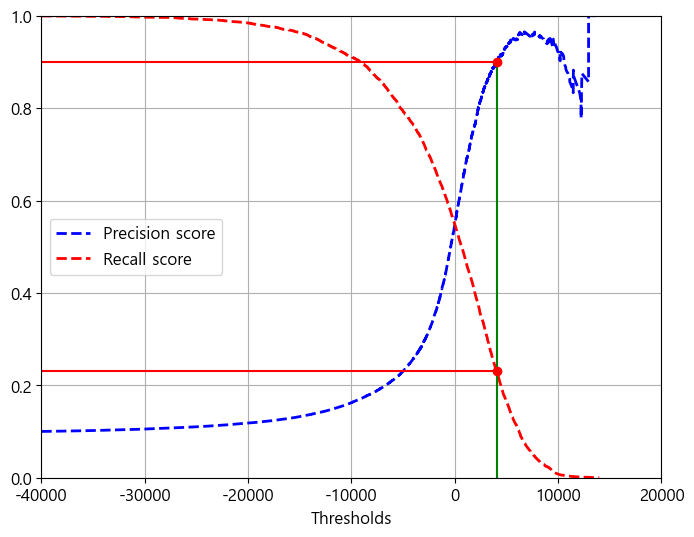

In [19]:
# 정밀도와 재현율의 tradeoff
# 정밀도와 재현율에 대한 그래프 출력

from sklearn.metrics import precision_recall_curve

# 정밀도, 재현율, 임계값 에 대한 데이터를 추출
precisions, recalls, thresholds = precision_recall_curve(y_train_8, y_scores)

# 정밀도와 재현율 그래프를 그리는 함수
def plot_precision_recall(precisions, recalls, thresholds):
    # 선 그리기
    plt.plot(thresholds, precisions[:-1], 'b--', 
            label = 'Precision score', linewidth = 2)
    plt.plot(thresholds, recalls[:-1], 'r--', 
            label = 'Recall score', linewidth = 2)
    # 범례 표시
    plt.legend(loc = 'center left', fontsize = 12)
    
    plt.xlabel('Thresholds', fontsize = 12)
    plt.grid(True)
    plt.axis([-40000, 20000, 0, 1])
    
plt.figure(figsize = (8, 6))
plot_precision_recall(precisions, recalls, thresholds)
    

# 정밀도가 0.9가 되는 위치의 재현율을 조회
recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

# 위치를 표시
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], 'g')
plt.plot([-40000, threshold_90_precision], [0.9, 0.9], 'r')
plt.plot([-40000, threshold_90_precision], 
         [recall_90_precision, recall_90_precision], 'r')
plt.plot([threshold_90_precision], [0.9], 'ro')
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')


plt.show()

In [20]:
# 정밀도가 0.9가 되는 지점을 이용해서 예측
# 정밀도가 0.9가 되는 위치의 threshold 를 찾고 그것을 기준으로 사용

y_train_predict_90 = (y_scores >= threshold_90_precision)

# 정밀도-  0.90
print(precision_score(y_train_8, y_train_predict_90)) 
# 재현율 - 0.23
print(recall_score(y_train_8, y_train_predict_90)) 

0.9003344481605351
0.23004614595795592


### ROC 곡선

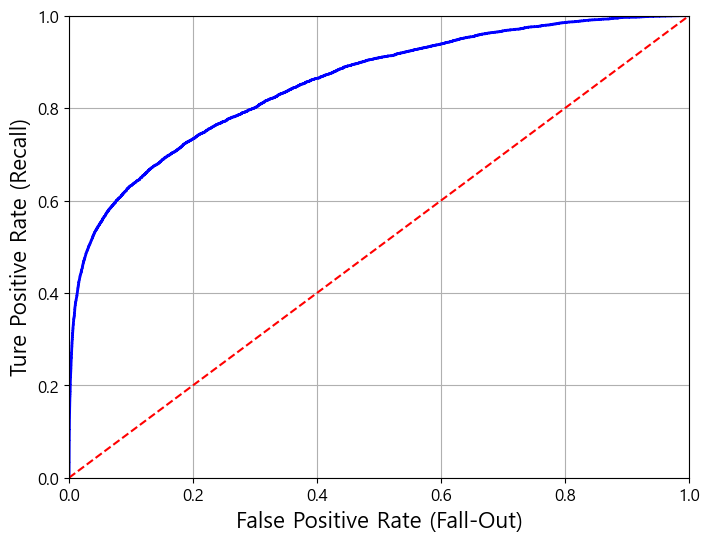

In [21]:
from sklearn.metrics import roc_curve

# 그래프에 사용할 값 계산
fpr, tpr, thresholds = roc_curve(y_train_8, y_scores)

# 그래프 출력 함수
def plot_roc_curve(fpr, tpr, label = None):
    # 선 그리기
    plt.plot(fpr, tpr, 'b', linewidth = 2, label = label) # ROC 곡선
    plt.plot([0, 1], [0, 1], 'r--') # 대각선 - 완전 랜덤인 경우
    # 좌표 볌위 설정
    plt.axis([0, 1, 0, 1])
    # 축 이름 표시
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize = 16)
    plt.ylabel('Ture Positive Rate (Recall)', fontsize = 16)
    plt.grid(True)

plt.figure(figsize = (8, 6))
plot_roc_curve(fpr, tpr, thresholds)
plt.show()

# 그래프의 점선이 완전 랜덤 분류기
# 점선으로부터 멀어지면 멀어질수록 좋은 분류기
# 가장 좋은 분류기는 그래프(분류기) 하단의 면적이 1인 그래프
# 변적의 값은 roc_auc_score 라는 함수로 계산이 가능함

In [22]:
# ROC 곡선의 면적 확인하기
# 면적이 1에 가까울수록 좋은 분류기

from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_8, y_scores)) # 0.8542

0.8542515125165044


## 다중 분류

### 이진 분류기를 이용한 다중 분류

In [23]:
from sklearn.svm import SVC

# 이진 분류기 SVC
svm_clf = SVC(gamma = 'auto', random_state = 21)
# 이진 분류기를 이용해서 0 ~ 9 까지 10가지를 분류
# 학습
svm_clf.fit(X_train[:1000], y_train[:1000])

print(svm_clf.predict([one_digit_image])) # 7

# 결정 점수를 확인 - 10개 점수 중 7에 대한 결정 점수가 가장 높음
digit_scores = svm_clf.decision_function([one_digit_image])
print(digit_scores)


[7]
[[ 3.937  8.193  4.986  1.872  7.111  0.86   2.885  9.197 -0.184  6.016]]


### SGD 분류기를 이용한 다중 분류

In [24]:
sgd.fit(X_train, y_train)

# 예측
print(sgd.predict([one_digit_image])) # 7

# 결정 점수 확인 - 7 의 점수가 가장 높음
print(sgd.decision_function([one_digit_image]))


[7]
[[-24068.136 -47985.984  -9597.819  -4298.995 -19424.024  -5481.485
  -31244.931  11684.673  -7032.156  -5727.669]]


In [25]:
# 교차 검증을 이용한 정확도 확인
cross_val_score(sgd, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.885, 0.848, 0.874])

In [26]:
# 특성이 여러 개이고 이 특성의 값의 분포가 일정하지 않은 경우
# scaling 이나 standaldization 을 고려해봐야 함

# 28x28 이미지라서 특성이 매우 많음
from sklearn.preprocessing import StandardScaler

# Scaling 적용
scaler = StandardScaler() # 객체 생성
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# 정확도 확인
cross_val_score(sgd, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')


array([0.901, 0.898, 0.902])

In [27]:
print(y_train)
print(y_train_predict)
print(y_train.shape)
print(y_train_predict.shape)

[5 0 4 ... 5 6 8]
[False False False ... False False  True]
(60000,)
(60000,)


In [28]:
# 오차 행렬 출력

# scoring 매개변수가 필요 없음
y_train_predict = cross_val_predict(sgd, X_train_scaled, 
                                  y_train, cv = 3)
confusion_mat = confusion_matrix(y_train, y_train_predict)
print(confusion_mat)

[[5593    0   23    8    9   41   35    6  207    1]
 [   0 6411   38   25    4   42    4    8  198   12]
 [  28   28 5264   93   72   27   65   40  331   10]
 [  23   20  123 5254    2  203   27   42  367   70]
 [  10   15   49   10 5226   11   37   25  293  166]
 [  29   17   32  173   54 4444   78   16  515   63]
 [  30   17   44    2   44   95 5562    3  120    1]
 [  21   11   53   30   50   10    3 5697  168  222]
 [  18   65   48   89    4  126   25   10 5419   47]
 [  25   20   30   68  117   32    1  177  325 5154]]


In [29]:
#help(confusion_matrix)

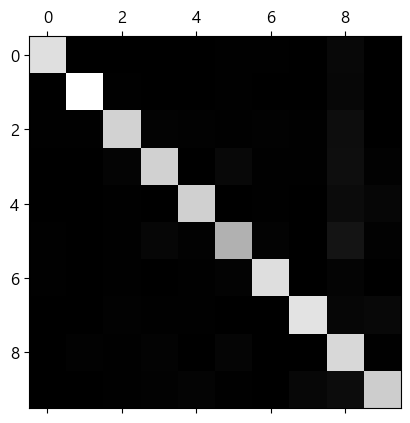

In [30]:
# 오차 행렬 시각화

plt.matshow(confusion_mat, cmap = plt.cm.gray)
plt.show()

# 오차 행렬의 결과를 확인해서 오류가 많이 발생하는 
# 특별한 상황이 있다면 이에 대한 해결책을 제시할 수 있음
# 오류가 많이 발생하는 클래스가 있다면 그 클래스의 데이터를 조금 더 넣어서
# 모델을 만들거나 결과가 나온 데이터를 가지고 다시 한 번 학습하는
# 모델을 만든다던가 하는 방식으로 전처리 작업을 수행

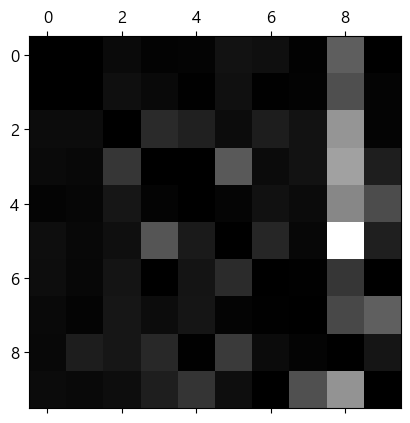

In [31]:
# 오차 행렬을 각 행의 합계로 나누고 대각선을 0으로 채워서
# 오류를 좀 더 눈에 듸게 출력하기
# 분류 모델에서는 이 행렬을 반드시 출력해보는 것이 좋음
# 잘못 분류됨 모델을 확인해볼 수 있음

# 클래스 별로 합계를 구함
row_sums = confusion_mat.sum(axis = 1, keepdims = True)
# 클래스 별 합계로 나누기
norm_confusion_mat = confusion_mat / row_sums

# 주 대각선 방향을 0 으로 채워 넣음
np.fill_diagonal(norm_confusion_mat, 0)
plt.matshow(norm_confusion_mat, cmap = plt.cm.gray)
plt.show()

## 다중 레이블 분류

In [32]:
# 출력해야 할 레이블이 여러 개인 경우
# 이미지를 가지고 7보다 큰지 그리고 홀수인지 여부를 같이 리턴해야 하는 경우

# KNN을 이용한 다중 레이블 분류
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

# 2개를 가지고 MultiLabel 생성
# 데이터를 배열로 제공
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([one_digit_image]) # array([[ True,  True]])
# 결과로 2개의 데이터를 갖는 배열을 리턴

array([[ True,  True]])

## 분류 알고리즘

### LDA(선형 판별 분석)

In [33]:
# borrowscore 와 payment_inc_ration 에 따른 outcome 선형 판별 분석

# 데이터 가져오기
loan3000 = pd.read_csv('./data/loan3000.csv')
print(loan3000.head())
loan3000.info()

   Unnamed: 0   outcome            purpose_    dti  borrower_score  \
0       32109  paid off  debt_consolidation  21.23            0.40   
1       16982   default         credit_card  15.49            0.40   
2       25335  paid off  debt_consolidation  27.30            0.70   
3       34580  paid off      major_purchase  21.11            0.40   
4       14424   default  debt_consolidation  16.46            0.45   

   payment_inc_ratio  
0            5.11135  
1            5.43165  
2            9.23003  
3            2.33482  
4           12.10320  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3000 non-null   int64  
 1   outcome            3000 non-null   object 
 2   purpose_           3000 non-null   object 
 3   dti                3000 non-null   float64
 4   borrower_score     3000 non-null   float64

In [34]:
# target 을 범주형으로 변환
loan3000.outcome = loan3000.outcome.astype('category')

# 숫자 컬럼들의 상관 계수 확인
#print(loan3000.corr())

# 독립 변수와 종속 변수를 설정
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

# 독립 변수 - feature
X = loan3000[predictors]
# 종속 변수 - target
y = loan3000[outcome]

print(X, y)

      borrower_score  payment_inc_ratio
0               0.40            5.11135
1               0.40            5.43165
2               0.70            9.23003
3               0.40            2.33482
4               0.45           12.10320
...              ...                ...
2995            0.50           18.36620
2996            0.60            1.80421
2997            0.20           15.42180
2998            0.45            8.92335
2999            0.40           12.88190

[3000 rows x 2 columns] 0       paid off
1        default
2       paid off
3       paid off
4        default
          ...   
2995    paid off
2996    paid off
2997     default
2998     default
2999     default
Name: outcome, Length: 3000, dtype: category
Categories (2, object): ['default', 'paid off']


In [35]:
# LDA 적용

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 객체 생성 및 적용
loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

# 최적의 값을 확인 - 'paid off' 와 'default' 의 경계 값
print(pd.DataFrame(loan_lda.scalings_, index = X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [36]:
# 처음 5개의 데이터에 대해 판별

# 각 데이터에 대해 'default' 일 확률과 'paid off' 일 확률을 나타냄
# predict_proba 함수는 각 클래스에 대한 확률을 나타냄
# loan_lda.classes_ 는 'default' 와 'paid off'
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                                           columns = loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


In [37]:
print(loan_lda.classes_)

['default' 'paid off']


### KNN 알고리즘을 이용한 분류

In [38]:
# loan200.csv 파일의 데이터를 읽어서 
# payment_inc_ratio 와 dti 를 이용해서 outcome을 예측
# 위와 같은 데이터를 사용하지만 분류에 사용하는 속성만 달라짐

from sklearn.neighbors import KNeighborsClassifier

loan200 = pd.read_csv('./data/loan200.csv')
#print(loan200.head())

predictors = [ 'payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]
print(X, y)


     payment_inc_ratio    dti
1              5.46933  21.33
2              6.90294   8.97
3             11.14800   1.83
4              3.72120  10.81
5              1.89923  11.34
..                 ...    ...
196           11.66300  26.09
197            2.97641  16.41
198            1.96846  19.98
199            9.64200  20.17
200            7.03924  13.88

[200 rows x 2 columns] 1       default
2      paid off
3      paid off
4       default
5      paid off
         ...   
196     default
197     default
198     default
199    paid off
200    paid off
Name: outcome, Length: 200, dtype: object


In [39]:
# 판단에 사용할 이웃의 갯수를 설정
knn = KNeighborsClassifier(n_neighbors = 20)

knn.fit(X, y)
# 예측 - 'paid off'
print(knn.predict(newloan))

['paid off']


In [40]:
# 확률을 확인 - [[0.45 0.55]]
print(knn.predict_proba(newloan))

[[0.45 0.55]]


### 표준화를 수행한 경우와의 차이

In [41]:
# 데이터 읽어오기

loan_data = pd.read_csv('./data/loan_data.csv.gz')
loan_data = loan_data.drop(columns = ['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],
                                     categories = ['paid off', 'default'],
                                     ordered = True)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
newloan = loan_data.loc[0:0, predictors]
# 데이터 확인
print(newloan)

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4


In [42]:
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

# 표준화를 하지 않으면 이웃을 찾을 때 특정 특성이 영향을 많이 미치게 됨
knn = KNeighborsClassifier(n_neighbors = 5)
# 훈련
knn.fit(X, y)

# 설정한 5개의 이웃에 대한 정보 출력
nbrs = knn.kneighbors(newloan)
print(nbrs)
print(X.iloc[nbrs[1][0],:])
# 'revol_bal' 데이터만 4자리 숫자로 편차의 차이가 크게 나타남
# 상대적으로 revol_bal 이 가까운 데이터가 선택되게 됨

(array([[1.556, 5.64 , 7.139, 8.842, 8.973]]), array([[35535, 33650, 25862, 42952, 43598]], dtype=int64))
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [43]:
# 정규화를 수행한 후 이웃 구하기

from sklearn import preprocessing

# 정규화 적용 - scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0) # 정수를 실수 데이터로 변환
X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

# knn 다시 적용
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0],:])
# 스케일링이 적용되어서 4가지 항목의 값들이 모두 변화
# 이전에 비해 revol_bal 을 제외한 나머지 속성들의 거리가 가까워짐
# 반대로 revol_bal 속성의 거리는 늘어남

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


### Logistic Regrssion - 선형 회귀

In [44]:
# 데이터 가져오기

from sklearn import datasets

iris = datasets.load_iris()
#print(iris.keys())

In [45]:
# 데이터 생성

# feature 생성 - 3번째 이후 속성만
# 꽃잎의 너비 속성 1가지에 대해서만 적용
X = iris.data[:, 3:]
# target - 2(virginica) 인지 여부
y = (iris['target'] == 2).astype(np.uint8)

#print(X, y)

In [46]:
# 모델 생성하기

from sklearn.linear_model import LogisticRegression

# 객체(모델) 생성
log_reg = LogisticRegression(solver = 'lbfgs', random_state = 21)

# 모델 훈련
log_reg.fit(X, y)

LogisticRegression(random_state=21)

In [47]:
# 샘플 데이터 1000개를 만들어서 예측
# 0 ~ 2 사이를 1000개로 분할하고 차원을 reshape
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)

# 각 샘플의 확률을 계산
y_proba = log_reg.predict_proba(X_new)

# 결정 경계 점수 - 확률이 0.5를 넘는 첫번째 지점
# 속성을 하나만 사용해서 분류
decision_bound = X_new[y_proba[:, 1] >= 0.5][0]
print(decision_bound) # 1.661
# 꽃잎의 너비가 1.661 보다 크다면 verginica 로 분류

# 여러 속성에 대해 분류를 해보고 싶다면
# 처음에 데이터를 생성할 때 X, y 에 여러 속성을 부여하면 됨

[1.661]


In [48]:
# 예측
print(log_reg.predict([[1.7], [1.67], [1.63], [1.4]])) # 1 1 0 0

[1 1 0 0]


## 0829 이어서

### Logistic Regression을 이용한 다중 클래스 분류(카테고리 분류)

In [52]:
# feature 생성
X = iris['data'][:,(2, 3)]
#print(X)

# iris 의 target 에는 3가지 종류가 속해있기 때문에
# 다중 클래스 분류가 됨
y = iris['target']
#print(y)

In [50]:
# 분류기 생성 및 훈련

# 분류기 생성 - LogisticRegression
# multi_class 는 다중 클래스이므로 multinomial
# C 는 규칙의 강도(규제)의 역수
softmax_reg = LogisticRegression(multi_class = 'multinomial',
                                solver = 'lbfgs', C = 10, random_state = 21)
# 훈련
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial', random_state=21)

In [51]:
# 샘플 데이터 생성 - 격자 모양 좌표

# meshgrid 는 격자 좌표 생성
# x0 는 500x500, x1 은 200x200 격자를 가지게 됨
# 반복문을 사용하는 것과 차이는 없음

# linspaace 는 범위 안에서 일정한 간격을 갖는 배열을 생성
x0, x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1),
    np.linspace(0, 3.5, 200).reshape(-1, 1),
)

# 샘플 데이터 - 예측에 사용
# ravel 은 flatten 처럼 하나의 행 또는 열로 만드는 함수
# 차이점은 flatten 과 다르게 원본 source 에도 변화의 영향을 미침
X_new = np.c_[x0.ravel(), x1.ravel()]

In [53]:
# 샘플 데이터를 가지고 예측

# 예측
y_predict = softmax_reg.predict(X_new)
print(y_predict)
# 예측에 사용한 확률 조회
y_proba = softmax_reg.predict_proba(X_new)
print(y_proba)

[0 0 0 ... 2 2 2]
[[1.000e+00 3.761e-06 6.800e-20]
 [1.000e+00 4.059e-06 7.857e-20]
 [1.000e+00 4.380e-06 9.079e-20]
 ...
 [7.738e-23 1.037e-11 1.000e+00]
 [6.697e-23 9.684e-12 1.000e+00]
 [5.796e-23 9.044e-12 1.000e+00]]


## Support Vector Machine

### 선형 SVM을 이용한 이진 분류

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

iris = datasets.load_iris()

# feature 는 2개만 사용
X = iris['data'][:, (2, 3)]
# 이진 분류를 수행하기 위해서 target 을 수정 - 2인지 아닌지
y = (iris['target'] == 2).astype(np.float64)

# 스케일링과 훈련을 실시할 모델을 pipeline 으로 구성
# 머신러닝이나 데이터 처리 등을 할 때 Pipeline 을 구성하는 것은 매우 중요함
# Pipeline을 구성하지 않고 순차적으로 처리해도 되지만 이런 경우 가독성이 떨어짐
svm_clf = Pipeline([
    # 스케이링
    ('scaler', StandardScaler()), 
    #LinearSVC 함수를 사용해서 모델 생성
    ('linear_svc', LinearSVC(C = 1, loss = 'hinge',
                            random_state = 21))
])
# 스케일링과 모델 생성을 따로 수행해도 됨
# svm 은 스케일링에 민감하므로 스케일링을 우선 적용

# 훈련
svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=21))])

In [58]:
# 훈련을 바탕으로 예측

# 훈련한 모델에 데이터를 입력해서 예측
# 데이터는 2차원 배열로 제공해야 함
# 결과로 1이 나오면 2번 클래스가 맞는 것이고 0이면 아님
print(svm_clf.predict([[1.5, 3.6]])) # [1.]
print(svm_clf.predict([[2.4, 1.9]])) # [0.]


[1.]
[0.]


### 비선형 SVM

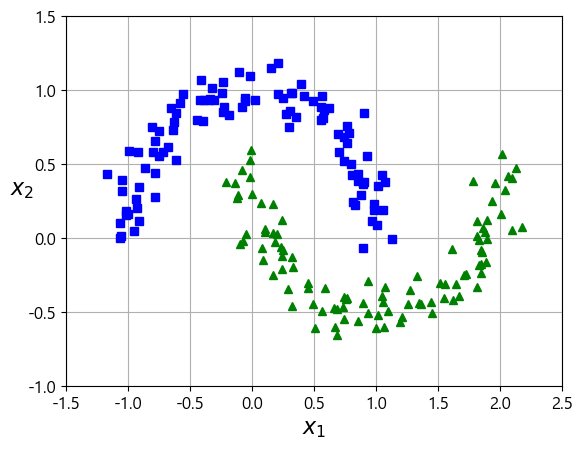

<Figure size 600x400 with 0 Axes>

In [64]:
# 비선형을 설명하기 위한 데이터 생성
from sklearn.datasets import make_moons

# n_samples 는 생성할 데이터의 수, noise 는 노이즈
X, y = make_moons(n_samples = 200, noise = 0.1, random_state = 21)

# 그래프 그리기 함수
def plot_dataset(X, y, axes):
    # y == 0 에 해당하는 데이터를 파란 사각형으로
    plt.plot(X[:,0][y == 0], X[:,1][y == 0], 'bs')
    # y == 1 에 해당하는 데이터를 녹색 삼각형으로
    plt.plot(X[:,0][y == 1], X[:,1][y == 1], 'g^')
    plt.axis(axes) # 축
    plt.grid(True, which = 'both') # 격자 보여주기
    plt.xlabel(r'$x_1$', fontsize = 16)
    plt.ylabel(r'$x_2$', fontsize = 16, rotation = 0)
    plt.figure(figsize = (6, 4))
    
# 생성한 데이터 확인
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [75]:
# 비선형 SVM을 이용해서 위의 데이터를 훈련

from sklearn.preprocessing import PolynomialFeatures

# pipeline 을 통해 모델 생성
# Poly 에서 degree 를 높이면 차수가 높아져서 곡선이 복잡해점
# 차수가 높아지면 훈련 데이터는 잘 구분하지만
# 새로운 데이터에 대해서는 잘 구분하지 못할 수 있음 - 과적합(overfitting)
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 5)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C = 10, loss = 'hinge', random_state = 21))
])

# 모델을 가지고 훈련
polynomial_svm_clf.fit(X, y)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=5)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=21))])

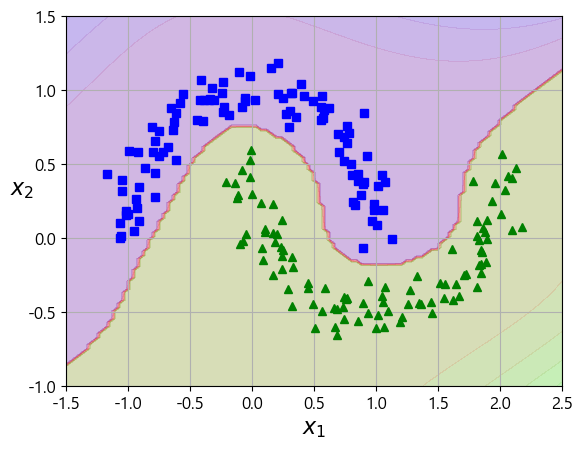

<Figure size 600x400 with 0 Axes>

In [76]:
# 결정 경계와 데이터의 분포를 시각화

def plot_predictions(clf, axes):
    # 샘플 데이터 생성
    x0 = np.linspace(axes[0], axes[1], 100)
    x1 = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0, x1)
    X = np.c_[x0.ravel(), x1.ravel()]
    # 예측
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    # 색칠하기
    plt.contourf(x0, x1, y_pred, cmap = plt.cm.brg, alpha = 0.2)
    plt.contourf(x0, x1, y_decision, cmap = plt.cm.brg, alpha = 0.1)
    
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

### 가우시안 RBF 커널을 이용한 비선형 SVM

In [81]:
from sklearn.svm import SVC

# 모델 생성

rbf_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    # 커널에 rbf 를 지정
    ('svm_clf',SVC(kernel = 'rbf', gamma = 5, random_state = 21))
])
# 하이퍼 파라미터 gamma 를 사용하는데 이 값을 증가시키면 
# 종 모양 그래프가 좁아지고 각 샘플의 영향 범위가 작아져서
# 결정 경계가 조금 더 불규칙해지며 작은 gamma 값은 넓은 종 모양
# 그래프를 만들어냄

# 훈련
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(gamma=5, random_state=21))])

In [78]:
#help(SVC)

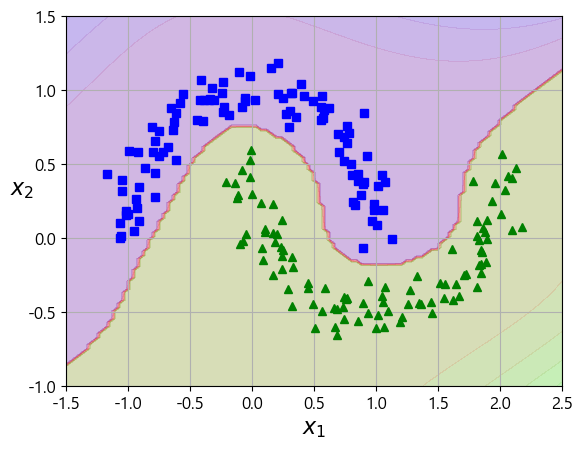

<Figure size 600x400 with 0 Axes>

In [82]:
# 결과를 시각화
# polynomial 이 모델에 없는데도 결과와 같이 비선형 SVM 을 구성
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

## Decision Tree

### 분류 모델의 생성 및 훈련과 시각화

In [84]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

lris = load_iris()

X = iris['data'][:, 2:]
y = iris['target']

# 모델 생성
tree_clf = DecisionTreeClassifier(max_depth = 2, random_state = 21)
# 훈련
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=21)

In [85]:
!pip install graphviz

     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00


In [86]:
# 시각화

from sklearn.tree import export_graphviz
import graphviz

# out_file 은 저장할 파일 이름(확장자는 dot)
# 데이터를 생성할 때 'X = iris['data'][:, 2:]' 를
# 사용 했으므로 feature_names 에서도 [2:] 를 사용
# class_naems 가 실제 이름
export_graphviz(
    tree_clf,
    out_file = 'iris_tree.dot',
    feature_names = iris.feature_names[2:],
    class_names = iris.target_names,
    rounded = True,
    filled = True
    )

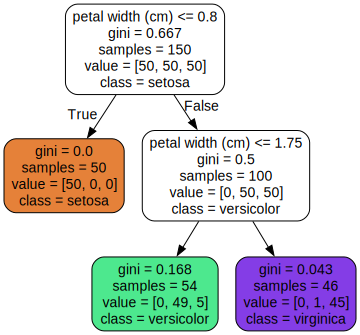

In [88]:
# 시각화의 결과를 화면에 출력

# Windows 는 아래와 같이 PATH 에 추가해줘야 함
os.environ['PATH'] += os.pathsep + 'C:/Program Files/Graphviz/bin'

# 파일 읽어오기
with open('iris_tree.dot') as f:
    dot_graph = f.read()

# 읽어온 내용 시각화
src = graphviz.Source(dot_graph)
src

In [91]:
# 예측
y_pred = tree_clf.predict([[3, 1.5]])
# 확률 예측
y_proba = tree_clf.predict_proba([[3, 1.5]])

print(y_pred, y_proba) 
# [1] [[0. 0.907 0.093]]


[1] [[0.    0.907 0.093]]


In [93]:
# feature 의 중요도
print(tree_clf.feature_importances_)

[0. 1.]


### 타이타닉 데이터를 이용한 생존 여부 분류 - 결정 트리 모델

In [55]:
# 데이터 가져오기

DF = sns.load_dataset('titanic')
# 데이터 확인
print(DF['survived'].value_counts())
DF.info()

0    549
1    342
Name: survived, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [56]:
# 결측치 처리

# deck 열은 결측치가 너무 많아서 열을 제거
# embark_town 열은 중복이므로 제거
rdf = DF.drop(['deck', 'embark_town'], axis = 1) # 열 제거는 axis=1
# age 열은 결측치가 많지 않기 때문에 결측치 데이터를 제거
rdf = rdf.dropna(subset = ['age'], axis = 0, how = 'any') # 행 제거는 axis=0
# embarked 열은 결측치가 2개라서 최빈값으로 대체 - 범주형이므로 최빈값
most_fre = rdf['embarked'].value_counts(dropna = True).idxmax()
rdf['embarked'].fillna(most_fre, inplace = True)

rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    714 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


In [4]:
rdf.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,no,True


In [57]:
# 분석에 사용할 열을 선택

ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  714 non-null    int64  
 1   pclass    714 non-null    int64  
 2   sex       714 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     714 non-null    int64  
 5   parch     714 non-null    int64  
 6   embarked  714 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.6+ KB


In [58]:
# 범주형 데이터(열)인지 확인
# 범주형일 때는 순서 여부를 확인해야 함
# 순서가 없을 때는 원핫 인코딩, 있는 경우에는 Oridinal 인코딩을 수행
ndf['sex'].unique()
# 결과가 male, female 2개 밖에 없으므로 범주형


array(['male', 'female'], dtype=object)

In [59]:
# 순서가 없는 범주형이므로 one hot 인코딩을 적용
onehot_sex = pd.get_dummies(ndf['sex'])
print(onehot_sex)

# 원핫 인코딩 결과를 원본 데이터에 추가
ndf = pd.concat([ndf, onehot_sex], axis = 1)
print(ndf.head())

     female  male
0         0     1
1         1     0
2         1     0
3         1     0
4         0     1
..      ...   ...
885       1     0
886       0     1
887       1     0
889       0     1
890       0     1

[714 rows x 2 columns]
   survived  pclass     sex   age  sibsp  parch embarked  female  male
0         0       3    male  22.0      1      0        S       0     1
1         1       1  female  38.0      1      0        C       1     0
2         1       3  female  26.0      0      0        S       1     0
3         1       1  female  35.0      1      0        S       1     0
4         0       3    male  35.0      0      0        S       0     1


In [60]:
# embarked 데이터도 범주형
ndf['embarked'].unique()

# 순서가 없는 범주형이므로 one hot 인코딩을 적용
# 1글자인 데이터이므로 혼동을 막고 구분해주기 위해 
# 앞에 prefix 를 추가 - town_C 형태
onehot_embarked = pd.get_dummies(ndf['embarked'], prefix = 'town')
print(onehot_embarked)

# 원핫 인코딩 결과를 원본 데이터에 추가
ndf = pd.concat([ndf, onehot_embarked], axis = 1)
#print(ndf.head())

     town_C  town_Q  town_S
0         0       0       1
1         1       0       0
2         0       0       1
3         0       0       1
4         0       0       1
..      ...     ...     ...
885       0       1       0
886       0       0       1
887       0       0       1
889       1       0       0
890       0       1       0

[714 rows x 3 columns]


In [61]:
# 원핫 인코딩 처리를 한 컬럼은 데이터에서 제거
ndf.drop(['sex', 'embarked'], axis = 1, inplace = True)
print(ndf.head())

   survived  pclass   age  sibsp  parch  female  male  town_C  town_Q  town_S
0         0       3  22.0      1      0       0     1       0       0       1
1         1       1  38.0      1      0       1     0       1       0       0
2         1       3  26.0      0      0       1     0       0       0       1
3         1       1  35.0      1      0       1     0       0       0       1
4         0       3  35.0      0      0       0     1       0       0       1


In [62]:
# feature 와 target 생성

# feature 는 survived 를 제외한 나머지
X = ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 
         'male', 'town_C', 'town_Q', 'town_S']]
# target
y = ndf['survived']

# 0이나 1처럼 작은 값들로 나타나는 나머지와 다르게
# age 컬럼은 22, 38과 같이 오차가 크게 나타남 - 정규화 필요
print(X.head())
print(y.head())

   pclass   age  sibsp  parch  female  male  town_C  town_Q  town_S
0       3  22.0      1      0       0     1       0       0       1
1       1  38.0      1      0       1     0       1       0       0
2       3  26.0      0      0       1     0       0       0       1
3       1  35.0      1      0       1     0       0       0       1
4       3  35.0      0      0       0     1       0       0       1
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


In [63]:
# feature 에 정규화를 수행

from sklearn import preprocessing

# age 와 같이 feature 값의 범위나 분포가 차이가 많이 나는 경우 수행
X = preprocessing.StandardScaler().fit(X).transform(X)
print(X)

[[ 0.911 -0.53   0.525 ... -0.472 -0.202  0.533]
 [-1.476  0.572  0.525 ...  2.12  -0.202 -1.876]
 [ 0.911 -0.255 -0.552 ... -0.472 -0.202  0.533]
 ...
 [-1.476 -0.737 -0.552 ... -0.472 -0.202  0.533]
 [-1.476 -0.255 -0.552 ...  2.12  -0.202 -1.876]
 [ 0.911  0.159 -0.552 ... -0.472  4.95  -1.876]]


In [64]:
# 훈련 데이터와 테스트 데이터를 분리

from sklearn.model_selection import train_test_split

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.3,
                                                   random_state = 21)

#print(X_train.shape)
#print(X_test.shape)

In [65]:
# 분류에 사용할 모델을 선택해서 훈련

# decision tree 모델 사용
from sklearn import tree

# 불순도(분류) 기준으로 entropy 사용
tree_model = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         max_depth = 5, random_state = 21)
# 훈련 데이터를 가지고 훈련
tree_model.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=21)

In [66]:
# 테스트 데이터를 가지고 예측
y_pred = tree_model.predict(X_test)
print(y_pred)

[0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0
 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1
 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0]


In [67]:
# 예측 결과와 실제 데이터 비교
print(y_pred[:15])
print(y_test.values[:15])

[0 0 0 1 0 0 0 0 0 1 0 0 0 1 1]
[0 0 0 1 0 0 1 0 0 1 0 0 0 1 0]


In [68]:
# 평가 지표 확인하기
from sklearn import metrics

# 오차 행렬 출력
tree_matrix = metrics.confusion_matrix(y_test, y_pred)
print(tree_matrix)

# 나머지 평가 지표 - precision, recall, f1 score
tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

[[117  19]
 [ 25  54]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       136
           1       0.74      0.68      0.71        79

    accuracy                           0.80       215
   macro avg       0.78      0.77      0.78       215
weighted avg       0.79      0.80      0.79       215



9
[0 1 2 3 4 5 6 7 8]
[0.267 0.213 0.105 0.    0.    0.409 0.007 0.    0.   ]


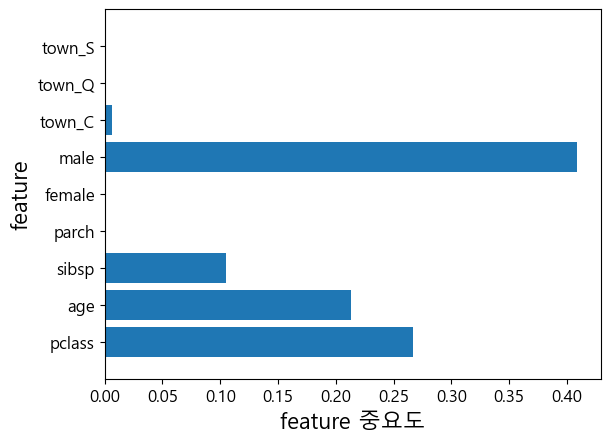

In [69]:
# feature의 중요도 확인

n_features = X.data.shape[1]
print(n_features) # 9
print(np.arange(n_features)) # feature가 몇개인지 확인
print(tree_model.feature_importances_) # 중요도 출력

plt.barh(np.arange(n_features), tree_model.feature_importances_, align = 'center')
plt.yticks(np.arange(n_features),
          ['pclass', 'age', 'sibsp', 'parch', 'female', 'male',
          'town_C', 'town_Q', 'town_S'])
plt.xlabel('feature 중요도', fontsize = 16)
plt.ylabel('feature', fontsize = 16)
plt.ylim(-1, n_features)

plt.show()

In [70]:
# grid search 방식 적용
from sklearn.model_selection import GridSearchCV

# 시도해 볼 파라미터 설정
params = {
    'max_depth' : [2, 4, 5, 6, 8, 10]
}

# grid search 방식을 수행해서 여러 파라미터에 대해 3번 적용
# 판단 기준은 accuracy(정확성)
grid_cv = GridSearchCV(tree_model, param_grid = params, 
                       scoring = 'accuracy', cv = 3, verbose = 1)
# 훈련
grid_cv.fit(X_train, y_train)

# 결과 출력
print('최고 정확도 : ', grid_cv.best_score_) # 0.805
print('최적 파라미터 : ', grid_cv.best_params_) # max_depth : 4

Fitting 3 folds for each of 6 candidates, totalling 18 fits
최고 정확도 :  0.8056657768799749
최적 파라미터 :  {'max_depth': 4}
